In [1]:
import matplotlib.pyplot as plt
from lbg_survey_metrics.cmb_xcorr import *
from lbg_survey_metrics.constants import *
from lbg_survey_metrics.galaxy_distribution import *
from lbg_survey_metrics.utils import cache_cmb_snr, get_lensing_noise

In [98]:
ell_, Cgg, Ckg, Ckk = calc_cross_spectra(24.75, "u")
ell_, Nkk = get_lensing_noise()

ell = np.arange(50, 2000, 100)
Cgg = np.interp(ell, ell_, Cgg)
Ckg = np.interp(ell, ell_, Ckg)
Ckk = np.interp(ell, ell_, Ckk)
Nkk = np.interp(ell, ell_, Nkk)

In [99]:
fsky = 1
n = 400
Ngg = 1 / (n * deg2_per_ster)

Covgg = 2 * (Cgg + Ngg)**2 / (2 * ell + 1) / fsky
Covkk = 2 * (Ckk + Nkk)**2 / (2 * ell + 1) / fsky
Covkg = ((Ckk + Nkk) * (Cgg + Ngg) + Ckg**2) / (2 * ell + 1) / fsky

In [100]:
Cov = np.block([[np.diag(Covgg), np.diag(Covkg)], [np.diag(Covkg), np.diag(Covkk)]])
Cov.shape

(40, 40)

In [101]:
np.linalg.inv(Cov);

In [102]:
ell

array([  50,  150,  250,  350,  450,  550,  650,  750,  850,  950, 1050,
       1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950])

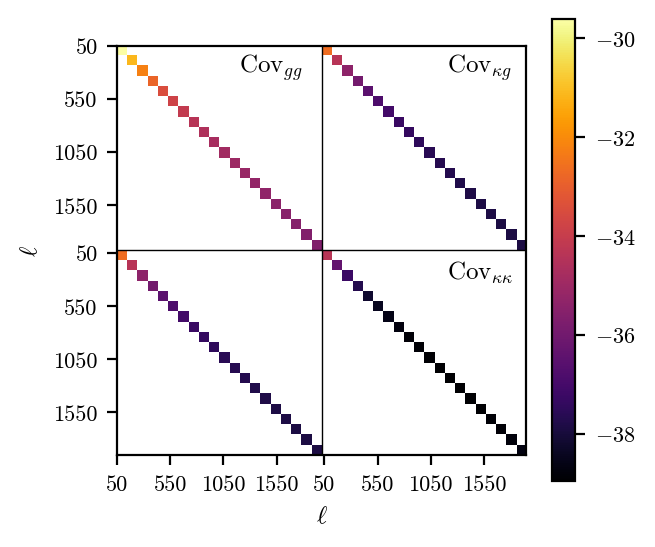

In [107]:
fig, ax = plt.subplots(figsize=single_col, dpi=200)
MIN = ell.min() - 0.5
MAX = 2 * ell.max() + 0.5
with np.errstate(divide='ignore'):
    im = ax.imshow(np.log(Cov), cmap="inferno", extent=(MIN, MAX, MAX, MIN))
fig.colorbar(im)

ticks = np.arange(ell.min(), ell.max(), 400).astype(int)
tick_locs = list(ticks) + list(ticks + ell.max())
tick_labels = list(ticks) + list(ticks)
ticks = ell[::5]
tick_locs = list(ticks) + list(ticks + ell.max())
tick_labels = list(ticks) + list(ticks)
#ticks = np.concatenate((ticks, ticks + ell[-1]))
ax.set(
    xticks=tick_locs,
    xticklabels=tick_labels,
    yticks=tick_locs,
    yticklabels=tick_labels,
    xlabel="$\ell$",
    ylabel="$\ell$",
)
ax.axvline(ell.max() + ell.min() / 2, lw=0.5, c="k")
ax.axhline(ell.max() + ell.min() / 2, lw=0.5, c="k")

text_x = 1200
text_y = 300
ax.text(text_x, text_y, "$\mathrm{Cov}_{gg}$")
ax.text(text_x + ell.max(), text_y, "$\mathrm{Cov}_{\kappa g}$")
ax.text(text_x + ell.max(), text_y + ell.max(), "$\mathrm{Cov}_{\kappa \kappa}$")

plt.show()

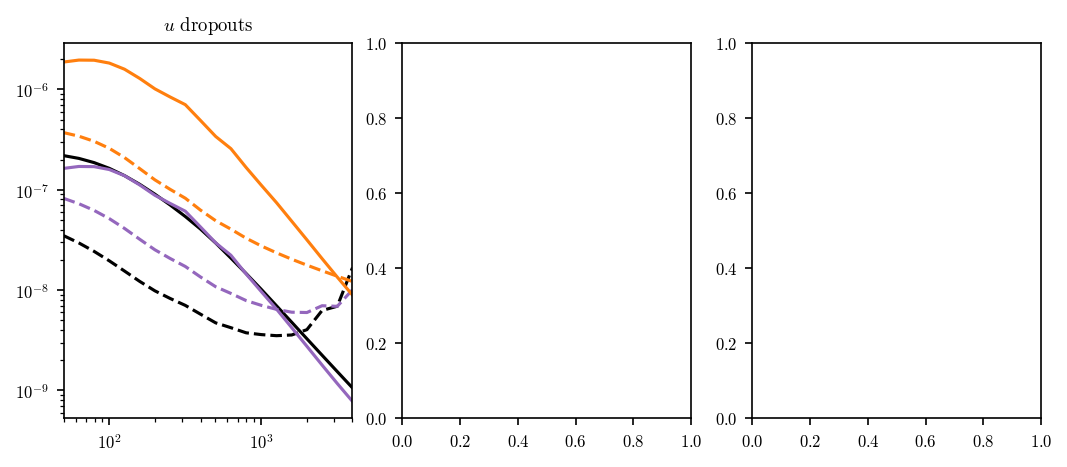

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=double_col, constrained_layout=True, dpi=150)

ax1.plot(ell, Ckk, c="k")
ax1.plot(ell, np.sqrt(Covkk), c="k", ls="--")

ax1.plot(ell, Ckg, c="C4")
ax1.plot(ell, np.sqrt(Covkg), c="C4", ls="--")

ax1.plot(ell, Cgg, c="C1")
ax1.plot(ell, np.sqrt(Covgg), c="C1", ls="--")

ax1.set(
    xscale="log",
    yscale="log",
    title="$u$ dropouts",
    xlim=(50, 4000),
)

plt.show()

In [108]:
def calc_snr(
    m5_det,
    lf_cut,
    m5_min,
    include_kg: bool = True,
    include_gg: bool = True,
    include_dd: bool = True,
    scale_dd: float = 1,
) -> float:
    # Check at that either kg or gg is enabled
    if not include_kg and not include_gg:
        raise ValueError("Atleast one of include_kg and include_gg must be true.")
        
    # Calculate number density
    n = map_number_density(...)

    # Get mean
    n_mean = n.mean()

    # And f_sky
    f_sky = ...

    # Calculate cross spectra
    ell, Cgg, Ckg, Ckk = calc_cross_spectra(...)
    Ngg = 1 / (n_mean * deg2_per_ster)  # galaxy shot noise

    # Calculate autocorrelation of density residuals
    if include_gg and include_dd:
        dd = (n - n_mean) / n_mean
        Cdd = ...
    else:
        Cdd = np.zeros_like(ell)

    # Calculate each covariance block
    Covgg = 2 * (Cgg + Ngg)**2 / (2 * ell + 1) / f_sky + Cdd
    Covkk = 2 * (Ckk + Nkk)**2 / (2 * ell + 1) / f_sky
    Covkg = ((Ckk + Nkk) * (Cgg + Ngg) + Ckg**2) / (2 * ell + 1) / f_sky

    # Assemble total covariance
    Cov = np.block([[np.diag(Covgg), np.diag(Covkg)], [np.diag(Covkg), np.diag(Covkk)]])

    # Concatenate signal
    signal = np.concatenate((Cgg, Ckg))

    # Calculate cumulative SNR
    invCov = np.linalg.inv(Cov)
    snr = np.dot(signal, invCov @ signal)

    return snr